# Dynamic Optimization with Pyomo.DAE
**Prepared by:** Prof. Alexander Dowling, Molly Dougher (mdoughe6@nd.edu, 2023)

In [ ]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    #!pip install casadi
    helper.install_idaes()
    helper.install_ipopt()
import numpy as np
import matplotlib.pyplot as plt

--2023-05-04 21:32:38--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7171 (7.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   7.00K  --.-KB/s    in 0s      

2023-05-04 21:32:38 (45.6 MB/s) - ‘helper.py’ saved [7171/7171]

Installing idaes via pip...
idaes was successfully installed
Running idaes get-extensions to install Ipopt, k_aug, and more...
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)

[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions

## Notebook Context
*Summary information taken from Section 10.1 of Biegler (2010)*

As seen in the previous notebooks (2.5 and 2.6), DAEs have a vast range of applications. The goal of this section is to provide the necessary theoretical background to now look at dynamic optimization of an NLP without an embedded DAE solver (Biegler Chapter 10). A multiperiod problem is considered with piecewise polynomial elements representing different states, leading to a discretization that is the same as the Runge-Kutta methods (Biegler Chapter 9).


## Quadrature Methods

First, the relevent background on quadrature is provided so that it can be applied to the following derivation of collocation methods. These topics are applied to an example in the next section on the website. See the following resources for further information on quadrature methods:

* Chapter 9 in [Biegler (2010)](https://epubs.siam.org/doi/book/10.1137/1.9780898719383)
* Chapter 17 in [McClarren (2018)](https://www.sciencedirect.com/book/9780128122532/computational-nuclear-engineering-and-radiological-science-using-python)

### Main Idea

The quadrature rule approximates the integral $I$ with weighted sum of function evaluations:

$$\begin{equation*}
I := \int_{-1}^{1} f(x) dx \approx \underbrace{\sum_{l=1}^{L} w_l f(x_l)}_{\text{quadrature rule}}
\end{equation*}$$

where:
* $x_l$ are nodes (also known as abscissas)
* $w_l$ are weights
* $n$ number of nodes and weights

Central questions:
* How to choose *nodes* and *weights*?
* How does this choice impact approximation error?
* How does $n$ impact approximation error?

### Recall: The degree and order of a polynomial

Consider the polynomial:

$$p(t) = a_0 + a_1 t + ... + a_K t^K.$$

$p(t)$ is said to be of **order K+1** as it has K+1 coefficients $a_0, ... a_K$.

The **degree** of the polynomial is the highest power with a non-zero coefficient. Thus if $a_K \neq 0$, then $p(t)$ is degree K.

### Gauss-Legendre Quadrature

For a *specific choice of nodes and weights*, the quadrature rule $\sum_{l=1}^{L} w_l f(x_l)$ is exact for integral $I$ if $f(x)$ is a polynomial of degree $2L-1$ or less. This specific case is the **optimal** (most accurate) rule known as the Gauss-Legendre quadrature.

The weights and nodes are given for $L$ up to 8:

<table>
<tbody><tr><td>$L$</td><td>$x_l$</td><td>$w_l$</td></tr></tbody>
<tbody><tr><td>1</td><td>0</td><td>2.0000000000000000000000000</td></tr></tbody>
<tbody><tr><td>2</td><td>±0.5773502691896257645091488</td><td>1.0000000000000000000000000</td></tr></tbody><p></p><tbody><tr><td rowspan="2">3</td><td>0</td><td>0.8888888888888888888888889</td></tr><tr><td>±0.7745966692414833770358531</td><td>0.5555555555555555555555556</td></tr></tbody><p></p><tbody><tr><td rowspan="2">4</td><td>±0.3399810435848562648026658</td><td>0.6521451548625461426269361</td></tr><tr><td>±0.8611363115940525752239465</td><td>0.3478548451374538573730639</td></tr></tbody><p></p><tbody><tr><td rowspan="3">5</td><td>0</td><td>0.5688888888888888888888889</td></tr><tr><td>±0.5384693101056830910363144</td><td>0.4786286704993664680412915</td></tr><tr><td>±0.9061798459386639927976269</td><td>0.2369268850561890875142640</td></tr></tbody><p></p><tbody><tr><td rowspan="3">6</td><td>±0.2386191860831969086305017</td><td>0.4679139345726910473898703</td></tr><tr><td>±0.6612093864662645136613996</td><td>0.3607615730481386075698335</td></tr><tr><td>±0.9324695142031520278123016</td><td>0.1713244923791703450402961</td></tr></tbody><p></p><tbody><tr><td rowspan="4">7</td><td>0</td><td>0.4179591836734693877551020</td></tr><tr><td>±0.4058451513773971669066064</td><td>0.3818300505051189449503698</td></tr><tr><td>±0.7415311855993944398638648</td><td>0.2797053914892766679014678</td></tr><tr><td>±0.9491079123427585245261897</td><td>0.1294849661688696932706114</td></tr></tbody><p></p><tbody><tr><td rowspan="4">8</td><td>±0.1834346424956498049394761</td><td>0.3626837833783619829651504</td></tr><tr><td>±0.5255324099163289858177390</td><td>0.3137066458778872873379622</td></tr><tr><td>±0.7966664774136267395915539</td><td>0.2223810344533744705443560</td></tr><tr><td>±0.9602898564975362316835609</td><td>0.1012285362903762591525314</td></tr></tbody>
</table>

### Why $2L-1$?

Let $f(x) = a_{2L-1} x^{2L-1} + a_{2L-2} x^{2L-2} + ... + a_{1} x^1 + a_{0}$

This polynomial has $2L$ coefficients. Likewise, $\int f(x)dx$ has $2L$ coefficients plus the constant of integration. This is the same number of degrees of freedom we have in choosing the *weights* and *nodes*.

### How to determine the nodes and weights? 

One way to derive the Gauss-Legendre quadrature rules is by looking at the integral generic monomials of degree 0 up to $2L-1$ and setting each equal to the $L$ point Gauss-Legendre quadrature rule:
$$ \int\limits_{-1}^{1} dx\, a_0 x^0 =  a_0\sum_{l=1}^L w_l x_l^0,$$
$$ \int\limits_{-1}^{1} dx\, a_1 x^1 = a_1\sum_{l=1}^L w_l x_l^1,$$
$$ \vdots $$
$$ \int\limits_{-1}^{1} dx\, a_{2L-1} x^{2L-1} = a_{2L-1}\sum_{l=1}^L w_l x_l^{2L-1}.$$
Notice that the $a_i$ **constants cancel out** of each equation so they do not matter. This system is $2L$ equations with $L$ weights, $w_l$, and $L$ nodes, $x_l$. We could solve these equations to get the weights and nodes, though this is not how it is done in practice generally---this is accomplished by using the theory of orthogonal polynomials.

### Code

In [ ]:
def GLQuad(f, L=8,dataReturn = False):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from -1 to 1
    Inputs:
    f:   name of function to integrate
    L:   Order of integration rule (8 or less)
    dataReturn:   determines whether weights and xs are returned
    
    Returns:
    G-L Quadrature estimate"""
    
    # Set bound on L
    assert(L>=1)

    # Enumerate over L to define weights and x in each scenario
    if (L==1):
        weights = np.ones(1)*2
        xs = np.array([0])
    elif (L==2):
        weights = np.ones(2)
        xs = np.array([-np.sqrt(1.0/3.0),np.sqrt(1.0/3.0)])
    elif (L==3):
        weights = np.array([0.8888888888888888888888889,
                            0.5555555555555555555555556,
                            0.5555555555555555555555556])
        xs = np.array([0.0,-0.7745966692414833770358531,
                       0.7745966692414833770358531])
    elif (L==4):
        weights = np.array([0.6521451548625461426269361,0.6521451548625461426269361,
                            0.3478548451374538573730639,0.3478548451374538573730639])
        xs = np.array([-0.3399810435848562648026658, 0.3399810435848562648026658,
                       -0.8611363115940525752239465, 0.8611363115940525752239465])
    elif (L==5):
        weights = np.array([0.5688888888888888888888889,
                            0.4786286704993664680412915,0.4786286704993664680412915,
                            0.2369268850561890875142640,0.2369268850561890875142640])
        xs = np.array([0.0,-0.5384693101056830910363144,0.5384693101056830910363144,
                       -0.9061798459386639927976269,0.9061798459386639927976269])
    elif (L==6):
        weights = np.array([0.4679139345726910473898703,0.4679139345726910473898703,
                            0.3607615730481386075698335,0.3607615730481386075698335,
                            0.1713244923791703450402961,0.1713244923791703450402961])
        xs = np.array([-0.2386191860831969086305017, 0.2386191860831969086305017,
                       -0.6612093864662645136613996, 0.6612093864662645136613996,
                       -0.9324695142031520278123016, 0.9324695142031520278123016])
    elif (L==7):
        weights = np.array([0.4179591836734693877551020,
                            0.3818300505051189449503698,0.3818300505051189449503698,
                            0.2797053914892766679014678,0.2797053914892766679014678,
                            0.1294849661688696932706114,0.1294849661688696932706114])
        xs = np.array([0.0,-0.4058451513773971669066064,0.4058451513773971669066064,
                       -0.7415311855993944398638648,0.7415311855993944398638648,
                       -0.9491079123427585245261897,0.9491079123427585245261897])
    elif (L==8):
        weights = np.array([0.3626837833783619829651504,0.3626837833783619829651504,
                            0.3137066458778872873379622,0.3137066458778872873379622,
                            0.2223810344533744705443560,0.2223810344533744705443560,
                            0.1012285362903762591525314,0.1012285362903762591525314])
        xs = np.array([-0.1834346424956498049394761, 0.1834346424956498049394761,
                       -0.5255324099163289858177390, 0.5255324099163289858177390,
                       -0.7966664774136267395915539, 0.7966664774136267395915539,
                       -0.9602898564975362316835609, 0.9602898564975362316835609])
    else: #use numpy's function
        xs, weights = np.polynomial.legendre.leggauss(L)
    
    # Calculate the quadrature estimate
    quad_estimate = np.sum(weights*f(xs))
    
    if (dataReturn):
        return quad_estimate, weights, xs
    else:
        return quad_estimate

### Visualize Weights

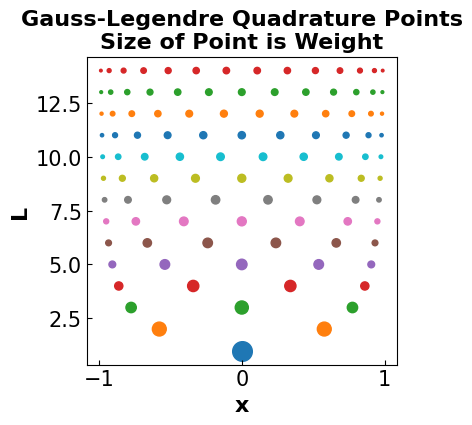

In [ ]:
# Establish L
L = np.arange(1,15)
# Define a lambda function
f = lambda x: x

# Define the figure
plt.figure(figsize=(4,4))

# Loop over L
for l in L:
    # Calculate quadrature estimate
    quad_est, weights, xs = GLQuad(f,l,dataReturn=True)
    levels = weights*0 + l
    plt.scatter(xs, levels, s=weights*100)

# Format the plot
plt.xlabel("x",fontsize=16, fontweight='bold')
plt.ylabel("L",fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)
plt.title("Gauss-Legendre Quadrature Points\nSize of Point is Weight",fontsize=16, fontweight='bold')
plt.show()

### Polynomial Example

As a simple demonstration of the Gauss-Legendre quadrature, let's show that it integrates polynomials of degree $2L-1$ exactly.  Consider the integral
$$\int\limits_{-1}^1 (x+1)^{2L-1}\,dx = \frac{2^{2 L-1}}{L}.$$

We can use the GLQuad function to evaluate the error.

In [ ]:
L = np.arange(1,12)
for l in L:
    
    # Create f
    f = lambda x: (x+1)**(2*l-1)
    
    # Evaluate exact (analytic) solution
    integral = 2**(2*l - 1)/l
    
    # Evaluate quadrature rule
    GLintegral = GLQuad(f,l)
    
    # Print results
    print("L =", l,"\t Estimate is",GLintegral,
          "Exact value is",integral, 
          "\nAbs. Relative Error is", np.abs(GLintegral-integral)/integral)

L = 1 	 Estimate is 2.0 Exact value is 2.0 
Abs. Relative Error is 0.0
L = 2 	 Estimate is 3.9999999999999996 Exact value is 4.0 
Abs. Relative Error is 1.1102230246251565e-16
L = 3 	 Estimate is 10.666666666666668 Exact value is 10.666666666666666 
Abs. Relative Error is 1.6653345369377348e-16
L = 4 	 Estimate is 31.99999999999999 Exact value is 32.0 
Abs. Relative Error is 3.3306690738754696e-16
L = 5 	 Estimate is 102.39999999999995 Exact value is 102.4 
Abs. Relative Error is 5.551115123125783e-16
L = 6 	 Estimate is 341.33333333333337 Exact value is 341.3333333333333 
Abs. Relative Error is 1.6653345369377348e-16
L = 7 	 Estimate is 1170.2857142857135 Exact value is 1170.2857142857142 
Abs. Relative Error is 5.828670879282072e-16
L = 8 	 Estimate is 4096.000000000003 Exact value is 4096.0 
Abs. Relative Error is 6.661338147750939e-16
L = 9 	 Estimate is 14563.555555555577 Exact value is 14563.555555555555 
Abs. Relative Error is 1.4988010832439613e-15
L = 10 	 Estimate is 52428.79

### Generalization

We are generally interested in integrals not just over the domain $x\in [-1,1]$.  We'll now make a function that does Gauss-Legendre quadrature over a general range using the formula
$$\int_a^b f(x)\,dx = \frac{b-a}{2} \int_{-1}^1 f\left(\frac{b-a}{2}z + \frac{a+b}{2}\right)\,dz.$$

In [ ]:
def generalGL(f,a,b,L):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from a to b
    Inputs:
    f:   name of function to integrate
    a:   lower bound of integral
    b:   upper bound of integral
    L:   Order of integration rule (8 or less)
    Returns:
    G-L Quadrature estimate"""
    
    # Set bound on L
    assert(L>=1)

    # Define a re-scaled f
    f_rescaled = lambda  z: f(0.5*(b-a)*z + 0.5*(a+b))

    # Define the integral
    integral = GLQuad(f_rescaled,L)

    # Calculate the G-L quadrature estimate
    return integral*(b-a)*0.5

Let's show that this version integrates polynomials of degree $2L-1$ exactly.  Consider the integral
$$\int\limits_{-3}^2 (x+1)^{2L-1}\,dx = \frac{9^L-4^L}{2 L}.$$

In [ ]:
L = np.arange(1,12)

# Loop over L to calculate the integral and the G-L estimate
for l in L:
    # Define a lambda function
    f = lambda x: (x+1)**(2*l-1)
    # Calculate the integral
    integral = (9**l-4**l)/(2*l)
    # Calculate the estimate
    GLintegral = generalGL(f,-3,2,l)
    # Print statement for the error comparison
    print("L =", l,"\t Estimate is",GLintegral,
          "Exact value is",integral, 
          "\nAbs. Relative Error is", np.abs(GLintegral-integral)/integral)

L = 1 	 Estimate is 2.5 Exact value is 2.5 
Abs. Relative Error is 0.0
L = 2 	 Estimate is 16.249999999999996 Exact value is 16.25 
Abs. Relative Error is 2.1862853408003084e-16
L = 3 	 Estimate is 110.83333333333336 Exact value is 110.83333333333333 
Abs. Relative Error is 2.5643647606379557e-16
L = 4 	 Estimate is 788.1249999999999 Exact value is 788.125 
Abs. Relative Error is 1.4424975444455643e-16
L = 5 	 Estimate is 5802.500000000002 Exact value is 5802.5 
Abs. Relative Error is 3.1348374037843283e-16
L = 6 	 Estimate is 43945.4166666667 Exact value is 43945.416666666664 
Abs. Relative Error is 8.278403262589113e-16
L = 7 	 Estimate is 340470.35714285733 Exact value is 340470.35714285716 
Abs. Relative Error is 5.128874777992276e-16
L = 8 	 Estimate is 2686324.0625 Exact value is 2686324.0625 
Abs. Relative Error is 0.0
L = 9 	 Estimate is 21508796.944444507 Exact value is 21508796.944444444 
Abs. Relative Error is 2.9443736549946913e-15
L = 10 	 Estimate is 174286791.24999988 Ex

### Radau Quadrature

Sometimes we desire either:
* The first node is at the beginning of the interval, i.e., $x_1 = -1$ or
* The last node is at the end of the interval, i.e., $x_{L} = 1$.

This is known as **Gauss-Radu quadrature**. The remaining nodes and weights are chosen optimally; thus, Radu quadrature *exactly* integrates *all* polynomials of degree $2L-2$ or less. Specifying one of the nodes leaves only $2L-1$ degrees of freedom.

More info: http://mathworld.wolfram.com/RadauQuadrature.html


### Differential Equations

Consider solving the differential equation

$$\dot{x} = f(t,x), \quad x(t_0) = x_0,$$

to determine $x(t_f)$. This can be expressed as an integral:

$$x(t_f) = \int_{t_0}^{t_f} \frac{dx}{dt} dt + x_0 = \underbrace{\int_{t_0}^{t_f} f(t, x(t)) dt}_{\text{quadrature rule}} + x_0$$

Thus, Runge-Kutta methods can be interpreted as a quadrature rule.

## Collocation Methods
See the following resources for more information on collocation:
* Chapter 10 in [Biegler (2010)](https://epubs.siam.org/doi/book/10.1137/1.9780898719383)

### What is a Collocation Method?
https://encyclopediaofmath.org/wiki/Collocation_method

Collocation methods are relevant to DAE systems because they are a way of numerically solving integral and differential equations. Given $n$ points (i.e., collocation points), the solution can be approximated such that conditions are satisfied at each collocation point. Then the approximate solution exists as a system of $n$ equations.

### Derivation of Collocation Methods
*Derivations are followed from Section 10.2 of Biegler (2010).*

Consider the following multiperiod dynamic optimization problem (8.5).

\begin{aligned}
\min & \sum_{l=1}^{N_T} \Phi^l\left(z^l\left(t_l\right), y^l\left(t_l\right), u^l\left(t_l\right), p^l\right) \\
\text { s.t. } & \frac{d z^l}{d t}=f^l\left(z^l(t), y^l(t), u^l(t), p^l\right), \quad z^l\left(t_{l-1}\right)=z_0^l, \\
& g^l\left(z^l(t), y^l(t), u^l(t), p^l\right)=0, \\
& u_L^l \leq u^l(t) \leq u_U^l, \\
& p_L^l \leq p^l \leq p_U^l, \\
& y_L^l \leq y^l(t) \leq y_U^l, \\
& z_L^l \leq z^l(t) \leq z_U^l, \quad t \in\left(t_{l-1}, t_l\right], l=1, \ldots, N_T, \\
& h\left(p, z_0^1, z^1\left(t_1\right), z_0^2, z^2\left(t_2\right), \ldots, z_0^{N_T}, z^{N_T}\left(t_{N_T}\right)\right)=0
\end{aligned}

The periods ($l$) can be represented by finite elements in time ($t$) and the state ($z$) and control variables ($u$) can be represented with polynomials (Figure 10.1).
 
![BieglerFigure10.1](https://github.com/mollydougher/optimization/blob/dougher-final-project/media/contrib/BieglerFigure10.1.png?raw=true)


The collocation method can be developed by solving the differential equation ($ dz/dt $) at specific time points. For example, Figure 10.1 shows the state variable approximation for a single finite element:

\begin{align}
z^k(t) = \alpha_0 + \alpha_1t + ... + \alpha_kt^k 
\end{align}

where $ \alpha_n $ are constants in the power series. This profile can also be represented as a Lagrange interpolation polynomial. Choosing $K+1$ interpolation points within element $i$, the state can be represented as:

\begin{align}
& t = t_{i-1} + h_i\tau , \\
& z^k(t) = \sum_{j=0}^K \ell_j(\tau)z_{ij} , \\
& \text{for } t \in [t_{i-1},t_i] \text{ and } \tau \in [0,1] , \\
& \text{where } \ell_j(\tau) = \prod_{k=0,\neq j}^K \frac{(\tau-\tau_k)}{(\tau_j-\tau_k)} \\
& \tau_0=0 \\
& \tau_j<\tau_{j+1}, \\
& j=0,...,K-1 , \\
& \text{and } h_i \text{ is the length of element } i. \\
\end{align}

The key property of this polynomial is that
$ z^K(t_{ij})=z_{ij} $ where $ t_{ij}=t_{i-1} + \tau_j h_i $.

We can do the same thing for the time derivative of the state (Lagrange polynomial with K interpolation points):

\begin{align}
z^k(t) = z_{i-1} + h_i \sum_{j=1}^K \Omega_j(\tau) \dot{z}_{ij} ,
\end{align}

where $z_{i-1}$ represents the differential state at the beginning of element $i$, $\dot{z}_{ij}$ is the time derivative, and $\Omega_j(\tau)$ is a $K^{th}$ order polynomial that satisfies:

\begin{align}
\Omega_j(\tau)=\int_0^{\tau}\ell_j(\tau')d\tau', \text{ }t \in [t_{i-1},t_i], \text{ }\tau \in [0,1]. 
\end{align}

Note that this is equivalent to the implcit Runge-Kutta (IRK) representation, where $n_s=k$, $C_k=\tau_k$, $a_{kj}=\Omega_j(\tau_k)$, and $b_k=\Omega_k(1)$. We can obtain $\ell_j$ and $\Omega_j$ from Gauss quadrature.

Collocation equations can be found by substituting the polynomial into the differential equation ($ dz/dt $). The algebraic equations must hold at each interpolation point $\tau_j$. The collocation equations for the Lagrange polynomial are:
\begin{align}
\sum_{j=0}^K z_{ij} \frac{d\ell_j(\tau_k)}{d\tau}=h_i f(z_{ik},t_{ik}), \text{ } k=1,...,K.
\end{align}

### Collocation with Orthogonal Polynomials
With the interpolation points $\tau_k$ known, then the collocation equations  become algebraic. Now $\tau_k$ must be determined such that the approximation is most accurate. Representing the solution as an integral:

\begin{align}
z(t_i) = z(t_{i-1}) + \int_{t_{i-1}}^{t_i} f(z(t),t)dt ,
\end{align}

the numerical solution is the quadrautre formula:

\begin{align}
& z(t_i) = z(t_{i-1}) + \sum_{j=1}^K \omega_j h_i f(z(t_{ij}), t_{ij}),
& t_{ij} = t_{i-1} + h_i \tau_j 
\end{align}

> **Theorem 10.1**: The quadrature formula (above) provides the exact solution to the integral (above) if $f(z(t),t)$ is a polynomial in $t$ of order $2K$ and $\tau_j$ are the roots of a $K$th degree polynomial, $P_K(\tau)$ with the property:
> 
> \begin{align}
& \int_0^1 P_j(\tau) P_{j'}(\tau)d\tau,
& j=0,...,K-1, 
& \text{ } j'=1,...,K, 
& \text{for indices } j \neq j'.
\end{align}

This theorem justifies choosing the collocation points ($\tau_j$) as the roots of $P_K(\tau)$. $P_K(\tau)$ is the shifted Gauss-Legendre polynomial that has the orthogonality property as shown by the result of the theorem. This polynomal can be broadly classified as a Gauss-Jacobi polynomial. See Section 10.2.2 of Biegler for more information. 

Using the roots of the Gauss-Jacobi polynomials as collocation points leads to the following results:
*  Gauss-Legrende collocation leads to trucation error of $O(h^{2k})$
* Gauss-Radau collocation leads to trucation error of $O(h^{2k-1})$

Generally, Gauss-Legendre and Radau collocation are compatible with NLP formulations.

### Applications to Runge-Kutta

When the Runge-Kutta basis is applied, the collocation method is seen to be an IRK method, leading to the following properties (established in Biegler Section 9.2):
* Collocation methods are A-stable (absolute stability) and Gauss-Legrende and Radau collocation are AN-stable (algebraically stable). Therefore,  $h_i$ has no stability limit (for stiff problems). This means large time steps $h_i$ can be used in systems where steady state components are captured and there are slow time scales.
* Radau collaction has stiff decay. Therefore, if your problem is stiff, try Radau collocation first. 
* Gauss-Legendre and Radau collocation methods have high-order error. (Here, order refers to $z_i$.)

### A Final Key Note

Continuity is enforced in states accross finite element boundaries, NOT controls or algebraic variables.